# Experimenting with a small extraction of the Netflix prize dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Read the dataset
dataset = pd.read_csv('../Data/Netflix/Small/dataset.csv')

# Display the dataset
dataset.head()

,Movie Index,User Index,Rating
0,0,383,4
1,0,439,3
2,0,938,5
3,0,581,2
4,0,91,3


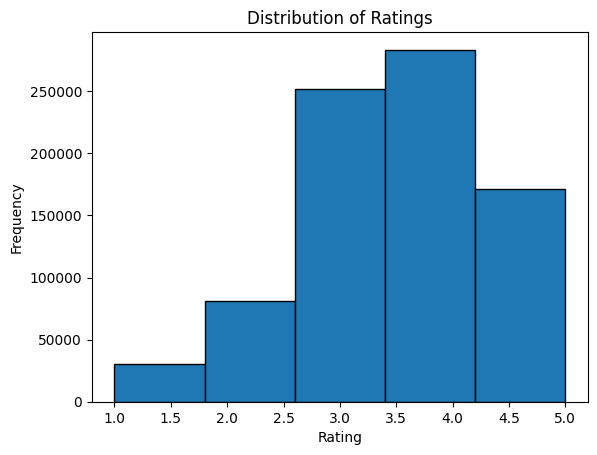

In [2]:
import matplotlib.pyplot as plt

# Plot the distribution of ratings
plt.hist(dataset['Rating'], bins=5, edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.show()

In [3]:
from sklearn.model_selection import train_test_split

# Split the dataset into train and test data
train_data, test_data = train_test_split(dataset, test_size=0.25, random_state=42)

# Print the shapes of train and test data
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (612631, 3)
Test data shape: (204211, 3)


In [4]:
import tensorflow as tf

# Convert train_data to sparse tensor
train_sparse_tensor = tf.sparse.SparseTensor(
    indices=train_data[['Movie Index', 'User Index']].values,
    values=train_data['Rating'].values,
    dense_shape=[dataset['Movie Index'].max() + 1, dataset['User Index'].max() + 1]
)
train_sparse_tensor = tf.sparse.reorder(train_sparse_tensor)

# Convert test_data to sparse tensor
test_sparse_tensor = tf.sparse.SparseTensor(
    indices=test_data[['Movie Index', 'User Index']].values,
    values=test_data['Rating'].values,
    dense_shape=[dataset['Movie Index'].max() + 1, dataset['User Index'].max() + 1]
)
test_sparse_tensor = tf.sparse.reorder(test_sparse_tensor)

2024-07-08 10:07:21.610329: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-08 10:07:21.636810: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-08 10:07:22.139413: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-07-08 10:07:22.615288: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-

## Evaluation methods

In [5]:
def nmse(y_true, y_pred, mask = None, rounded = True):
    if rounded:
        # Round y_pred to the nearest integer between 1 and 5
        y_pred = tf.clip_by_value(tf.round(y_pred), 1, 5)

    # If mask is not provided, calculate NMSE for the whole tensor
    if mask == None:
        return tf.reduce_sum(tf.square(y_true - y_pred)) / tf.reduce_sum(tf.square(y_true)).numpy()
    else:
        return (tf.reduce_sum(tf.square(tf.boolean_mask(y_true - y_pred, mask))) / tf.reduce_sum(tf.square(tf.boolean_mask(y_true, mask)))).numpy()
    
def nmse_numpy(y_true, y_pred, mask = None, rounded = True):
    if rounded:
        # Round y_pred to the nearest integer between 1 and 5
        y_pred = np.clip(np.round(y_pred), 1, 5)

    # If mask is not provided, calculate NMSE for the whole tensor
    if len(np.shape(mask)) == 0:
        return np.sum((y_true - y_pred) ** 2) / np.sum(y_true ** 2)
    else:
        return np.sum(((y_true - y_pred) * mask) ** 2) / np.sum((y_true * mask) ** 2)

In [6]:
class Evaluation():
    def __init__(self, model, train_sparse_tensor, test_sparse_tensor, loss_fn, **kwargs):
        self.model = model
        self.loss_fn = loss_fn
        self.train_sparse_tensor = train_sparse_tensor
        self.test_sparse_tensor = test_sparse_tensor
        self.kwargs = kwargs

    def evaluate_train_vs_test_losses(self, num_factors, num_iters):
        results = self.model(self.train_sparse_tensor, self.test_sparse_tensor, self.loss_fn, num_factors, num_iters, **self.kwargs)
        train_losses = results[-2]
        test_losses = results[-1]

        # Plot the train and test losses
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        best_iter = np.argmin(test_losses)
        return best_iter, train_losses[best_iter], test_losses[best_iter]

    def evaluate_num_factors(self, num_factors_list, num_iters):
        train_losses = []
        test_losses = []

        for num_factors in num_factors_list:
            results = self.model(self.train_sparse_tensor, self.test_sparse_tensor, self.loss_fn, num_factors, num_iters, **self.kwargs)
            train_loss = results[-2]
            test_loss = results[-1]
            train_losses.append(train_loss[-1])
            test_losses.append(test_loss[-1])

        # Plot the train and test losses
        plt.plot(num_factors_list, train_losses, label='Train Loss')
        plt.plot(num_factors_list, test_losses, label='Test Loss')
        plt.xlabel('Number of Factors')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        best_factors = num_factors_list[np.argmin(test_losses)]
        return best_factors, train_losses[np.argmin(test_losses)], np.min(test_losses)


    def evaluate_num_iters(self, num_factors, num_iters_list):
        train_losses = []
        test_losses = []

        for num_iters in num_iters_list:
            results = self.model(self.train_sparse_tensor, self.test_sparse_tensor, self.loss_fn, num_factors, num_iters, **self.kwargs)
            train_loss = results[-2]
            test_loss = results[-1]
            train_losses.append(train_loss[-1])
            test_losses.append(test_loss[-1])

        # Plot the train and test losses
        plt.plot(num_iters_list, train_losses, label='Train Loss')
        plt.plot(num_iters_list, test_losses, label='Test Loss')
        plt.xlabel('Number of Iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        best_iters = num_iters_list[np.argmin(test_losses)]
        return best_iters, train_losses[np.argmin(test_losses)], np.min(test_losses)
    
    def give_example(self, num_factors, num_iters, num_samples):
        results = self.model(self.train_sparse_tensor, self.test_sparse_tensor, self.loss_fn, num_factors, num_iters, **self.kwargs)
        C = results[0]
        X = results[1]
        
        # Check if C and X are tensors or numpy arrays
        if isinstance(C, tf.Tensor):
            C = C.numpy()
            X = X.numpy()

        # Get predictions
        predictions = C @ X

        # Get random sample indices from the test tensor indices
        indices = np.random.choice(test_sparse_tensor.indices.numpy().shape[0], num_samples, replace=False)
        sample_indices = test_sparse_tensor.indices.numpy()[indices]

        # Print the predictions and actual ratings
        for i in range(num_samples):
            movie_index = sample_indices[i][0]
            user_index = sample_indices[i][1]
            actual_rating = test_sparse_tensor.values.numpy()[indices[i]]
            predicted_rating = predictions[movie_index, user_index]
            print(f"Movie Index: {movie_index}, User Index: {user_index}, Actual Rating: {actual_rating}, Predicted Rating: {predicted_rating}")

## NMF

In [7]:
# Implement the Non-negative Matrix Factorization algorithm
def NMF(train_sparse_tensor, test_sparse_tensor, loss_fn, num_factors, num_iters):
    # Convert the sparse tensor to dense tensor
    train_tensor = tf.cast(tf.sparse.to_dense(train_sparse_tensor), tf.float32)
    test_tensor = tf.cast(tf.sparse.to_dense(test_sparse_tensor), tf.float32)

    # Create masks
    train_M = tf.cast(tf.not_equal(train_tensor, 0), tf.float32)
    test_M = tf.cast(tf.not_equal(test_tensor, 0), tf.float32)

    # Initialize the user and movie factors
    init_scale = tf.divide(tf.reduce_mean(tf.boolean_mask(train_tensor, train_M)), num_factors)
    C = tf.Variable(tf.multiply(tf.random.truncated_normal([train_sparse_tensor.dense_shape[0], num_factors], mean=1.0, stddev=0.02), init_scale))
    X = tf.Variable(tf.multiply(tf.random.truncated_normal([num_factors, train_sparse_tensor.dense_shape[1]], mean=1.0, stddev=0.02), init_scale))

    # Initialize the loss
    train_losses = []
    test_losses = []

    # Perform matrix factorization
    for i in range(num_iters):
        # Update user factors
        C.assign(tf.multiply(
            C, 
            tf.math.divide_no_nan(
                tf.matmul(train_tensor, tf.transpose(X)),
                tf.matmul(tf.multiply(train_M, tf.matmul(C, X)), tf.transpose(X)))))

        # Update movie factors
        X.assign(tf.multiply(
            X, 
            tf.math.divide_no_nan(
                tf.matmul(tf.transpose(C), train_tensor),
                tf.matmul(tf.transpose(C), tf.multiply(train_M, tf.matmul(C, X))))))

        # Compute the loss
        pred = tf.matmul(C, X)
        train_losses.append(loss_fn(train_tensor, pred, train_M))
        test_losses.append(loss_fn(test_tensor, pred, test_M))

    return C, X, train_losses, test_losses

In [8]:
def NMF_numpy(train_sparse_tensor, test_sparse_tensor, loss_fn, num_factors, num_iters):
    # Convert the sparse tensor to dense tensor
    train_tensor = tf.cast(tf.sparse.to_dense(train_sparse_tensor), tf.float32).numpy()
    test_tensor = tf.cast(tf.sparse.to_dense(test_sparse_tensor), tf.float32).numpy()

    # Create masks
    train_M = np.not_equal(train_tensor, 0).astype(float)
    test_M = np.not_equal(test_tensor, 0).astype(float)

    # Initialize the user and movie factors
    init_scale = np.mean(train_tensor[train_M == 1]) / num_factors
    C = np.random.normal(1.0, 0.02, (train_sparse_tensor.shape[0], num_factors)) * init_scale
    X = np.random.normal(1.0, 0.02, (num_factors, train_sparse_tensor.shape[1])) * init_scale

    # Initialize the loss
    train_losses = []
    test_losses = []

    # Perform matrix factorization
    for i in range(num_iters):
        # Update user factors
        temp = np.matmul(np.multiply(train_M, np.matmul(C, X)), X.T)
        C = C * np.divide(
            np.matmul(train_tensor, X.T),
            temp,
            out=np.zeros_like(C), where= temp != 0)

        # Update movie factors
        temp = np.matmul(C.T, np.multiply(train_M, np.matmul(C, X)))
        X = X * np.divide(
            np.matmul(C.T, train_tensor),
            temp,
            out=np.zeros_like(X), where= temp != 0)

        # Compute the loss
        pred = np.matmul(C, X)
        train_losses.append(loss_fn(train_tensor, pred, train_M))
        test_losses.append(loss_fn(test_tensor, pred, test_M))

    return C, X, train_losses, test_losses

In [9]:
# Apply NMF on the dataset
nmf = Evaluation(model=NMF_numpy, loss_fn=nmse_numpy, train_sparse_tensor=train_sparse_tensor, test_sparse_tensor=test_sparse_tensor)

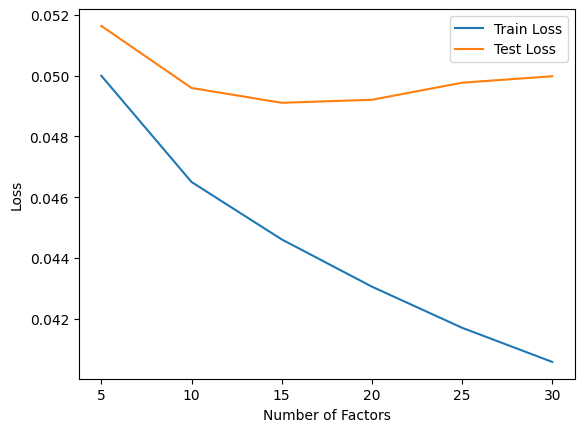

Best Number of Factors: 15
Train Loss: 0.0446074151461865
Test Loss: 0.049107855855956825


In [10]:
best_factors, train_loss, test_loss = nmf.evaluate_num_factors(num_factors_list=np.arange(5, 35, 5), num_iters=500)
print("Best Number of Factors:", best_factors)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

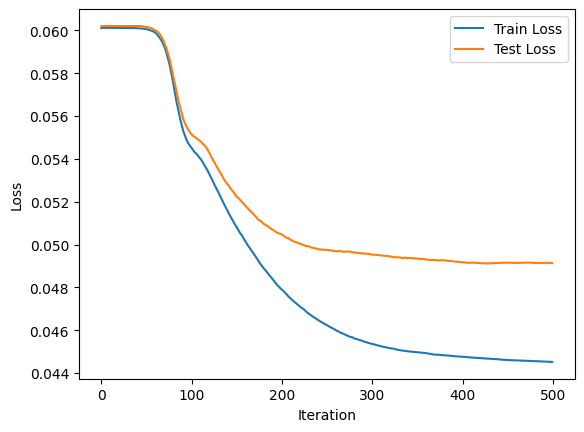

Best Iteration: 428
Train Loss: 0.044670187932153584
Test Loss: 0.04911030757117679


In [11]:
best_iter, train_loss, test_loss = nmf.evaluate_train_vs_test_losses(num_factors=best_factors, num_iters=500)
print("Best Iteration:", best_iter)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

In [12]:
nmf.give_example(num_factors=best_factors, num_iters=best_iter, num_samples=20)

Movie Index: 914, User Index: 122, Actual Rating: 4, Predicted Rating: 3.726850429253575
Movie Index: 556, User Index: 542, Actual Rating: 5, Predicted Rating: 3.963308483515936
Movie Index: 152, User Index: 686, Actual Rating: 3, Predicted Rating: 3.0844688589006424
Movie Index: 19, User Index: 198, Actual Rating: 3, Predicted Rating: 3.573925729519686
Movie Index: 278, User Index: 177, Actual Rating: 4, Predicted Rating: 3.9670398954071597
Movie Index: 473, User Index: 779, Actual Rating: 2, Predicted Rating: 3.2804786156521484
Movie Index: 43, User Index: 618, Actual Rating: 5, Predicted Rating: 4.777504443896155
Movie Index: 176, User Index: 620, Actual Rating: 3, Predicted Rating: 4.082593551121365
Movie Index: 5, User Index: 662, Actual Rating: 3, Predicted Rating: 3.1210326453875337
Movie Index: 502, User Index: 905, Actual Rating: 3, Predicted Rating: 2.954916892284573
Movie Index: 640, User Index: 940, Actual Rating: 3, Predicted Rating: 2.94804907863367
Movie Index: 153, User

## MVGMF

In [13]:
def MVGMF(train_sparse_tensor, test_sparse_tensor, loss_fn, num_factors, num_iters, k, sigma):
    # Convert the sparse tensor to dense tensor
    train_tensor = tf.cast(tf.sparse.to_dense(train_sparse_tensor), tf.float32)
    test_tensor = tf.cast(tf.sparse.to_dense(test_sparse_tensor), tf.float32)

    # Create masks
    train_M = tf.cast(tf.not_equal(train_tensor, 0), tf.float32)
    test_M = tf.cast(tf.not_equal(test_tensor, 0), tf.float32)

    # Initialize the user and movie factors
    m = train_sparse_tensor.dense_shape[0]
    n = train_sparse_tensor.dense_shape[1]
    init_scale = tf.divide(tf.reduce_mean(tf.boolean_mask(train_tensor, train_M)), num_factors)
    C = tf.Variable(tf.multiply(tf.random.truncated_normal([m, num_factors], mean=1.0, stddev=0.02), init_scale))
    X = tf.Variable(tf.multiply(tf.random.truncated_normal([num_factors, n], mean=1.0, stddev=0.02), init_scale))
    V = tf.Variable(tf.multiply(tf.eye(num_factors, dtype=tf.float32), k))
    W = tf.Variable(tf.multiply(tf.eye(num_factors, dtype=tf.float32), k))

    # Initialize the loss
    train_losses = []
    test_losses = []

    # Perform optimization
    for i in range(num_iters):
        # temp_cv = VX(\sigma^2I+X^TVX)^-1
        temp_cv = tf.matmul(
            tf.matmul(V, X),
            tf.linalg.pinv(
                tf.add(
                    tf.multiply(tf.eye(n), sigma ** 2), 
                    tf.matmul(tf.transpose(X), tf.matmul(V, X))
                )
            )
        )

        # C = C + (M*(Y-CX))(temp_cv^T)
        C.assign(tf.add(
            C, 
            tf.matmul(
                tf.multiply(train_M, tf.subtract(train_tensor, tf.matmul(C, X))), 
                tf.transpose(temp_cv)
            )
        ))
        
        # V = V - temp_cv X^TV
        V.assign(tf.subtract(
            V,
            tf.matmul(
                temp_cv,
                tf.matmul(tf.transpose(X), V)
            )
        ))
        
        # temp_XW = WC^T(\sigma^2I+CWC^T)^-1
        temp_xw = tf.matmul(
            tf.matmul(W, tf.transpose(C)),
            tf.linalg.pinv(
                tf.add(
                    tf.multiply(tf.eye(m), sigma ** 2), 
                    tf.matmul(tf.matmul(C, W), tf.transpose(C))
                )
            )
        )
        
        # X = X + temp_xw(M*(Y-CX))
        X.assign(tf.add(
            X, 
            tf.matmul(
                temp_xw,
                tf.multiply(train_M, tf.subtract(train_tensor, tf.matmul(C, X)))
            )
        ))

        # W = W - temp_xw CW
        W.assign(tf.subtract(
            W,
            tf.matmul(
                temp_xw,
                tf.matmul(C, W)
            )
        ))

        # Compute the train and test losses
        pred = tf.matmul(C, X)
        train_losses.append(loss_fn(train_tensor, pred, train_M))
        test_losses.append(loss_fn(test_tensor, pred, test_M))
    
    return C, X, V, W, train_losses, test_losses    

In [14]:
def MVGMF_numpy(train_sparse_tensor, test_sparse_tensor, loss_fn, num_factors, num_iters, k, sigma):
    # Convert the sparse tensor to dense tensor
    train_tensor = tf.cast(tf.sparse.to_dense(train_sparse_tensor), tf.float32).numpy()
    test_tensor = tf.cast(tf.sparse.to_dense(test_sparse_tensor), tf.float32).numpy()

    # Create masks
    train_M = np.not_equal(train_tensor, 0).astype(float)
    test_M = np.not_equal(test_tensor, 0).astype(float)

    # Initialize the user and movie factors
    m = train_tensor.shape[0]
    n = train_tensor.shape[1]
    init_scale = np.mean(train_tensor[train_M == 1]) / num_factors
    C = np.random.normal(1.0, 0.02, (m, num_factors)) * init_scale
    X = np.random.normal(1.0, 0.02, (num_factors, n)) * init_scale
    V = np.eye(num_factors) * k
    W = np.eye(num_factors) * k

    # Initialize the loss
    train_losses = []
    test_losses = []

    # Perform optimization
    for i in range(num_iters):
        # temp_cv = VX(\sigma^2I+X^TVX)^-1
        temp_cv = V @ X @ np.linalg.inv(np.eye(n) * sigma ** 2 + X.T @ V @ X)

        # C = C + (M*(Y-CX))(temp_cv^T)
        C = C + train_M * (train_tensor - C @ X) @ temp_cv.T
        
        # V = V - temp_cv X^TV
        V = V - temp_cv @ X.T @ V
        
        # temp_XW = WC^T(\sigma^2I+CWC^T)^-1
        temp_xw = W @ C.T @ np.linalg.inv(np.eye(m) * sigma ** 2 + C @ W @ C.T)
        
        # X = X + temp_xw(M*(Y-CX))
        X = X + temp_xw @ (train_M * (train_tensor - C @ X))

        # W = W - temp_xw CW
        W = W - temp_xw @ C @ W

        # Compute the train and test losses
        pred = C @ X
        train_losses.append(loss_fn(train_tensor, pred, train_M))
        test_losses.append(loss_fn(test_tensor, pred, test_M))

    return C, X, V, W, train_losses, test_losses

In [15]:
# Apply MVGMF on the dataset
mvgmf = Evaluation(model=MVGMF, loss_fn=nmse, train_sparse_tensor=train_sparse_tensor, test_sparse_tensor=test_sparse_tensor, k=40, sigma=0.2)

2024-07-08 10:08:06.875935: I tensorflow/core/util/cuda_solvers.cc:178] Creating GpuSolver handles for stream 0x55599f7e5e70


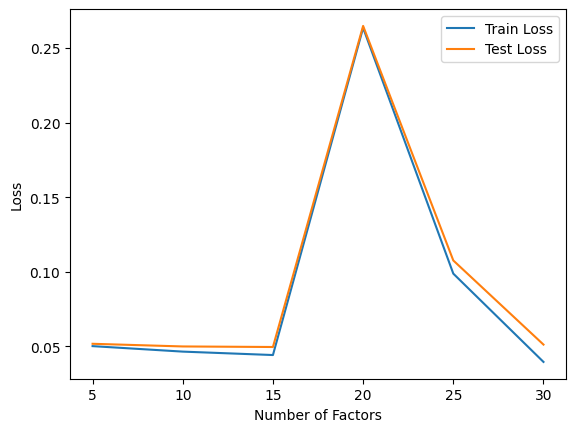

Best Number of Factors: 15
Train Loss: 0.04407023
Test Loss: 0.049461603


In [16]:
best_factors, train_loss, test_loss = mvgmf.evaluate_num_factors(num_factors_list=np.arange(5, 35, 5), num_iters=500)
print("Best Number of Factors:", best_factors)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

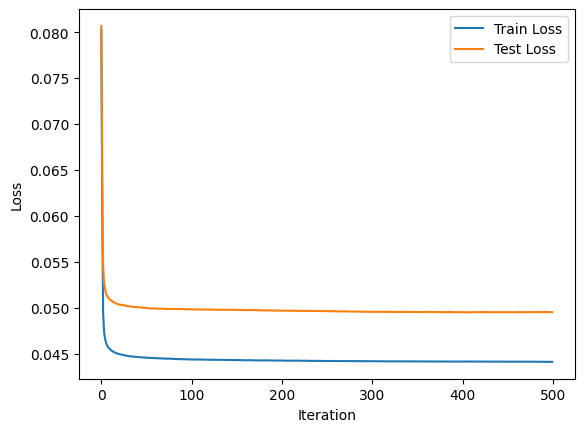

Best Iteration: 405
Train Loss: 0.044127986
Test Loss: 0.049481567


In [17]:
best_iter, train_loss, test_loss = mvgmf.evaluate_train_vs_test_losses(num_factors=best_factors, num_iters=500)
print("Best Iteration:", best_iter)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

In [18]:
mvgmf.give_example(num_factors=best_factors, num_iters=best_iter, num_samples=20)

Movie Index: 756, User Index: 37, Actual Rating: 4, Predicted Rating: 3.4580249786376953
Movie Index: 379, User Index: 256, Actual Rating: 3, Predicted Rating: 3.4079957008361816
Movie Index: 904, User Index: 125, Actual Rating: 2, Predicted Rating: 2.8144633769989014
Movie Index: 43, User Index: 618, Actual Rating: 5, Predicted Rating: 5.215184688568115
Movie Index: 989, User Index: 685, Actual Rating: 4, Predicted Rating: 3.4855551719665527
Movie Index: 132, User Index: 961, Actual Rating: 3, Predicted Rating: 2.886866569519043
Movie Index: 6, User Index: 950, Actual Rating: 5, Predicted Rating: 4.384995460510254
Movie Index: 794, User Index: 821, Actual Rating: 2, Predicted Rating: 3.583934783935547
Movie Index: 521, User Index: 82, Actual Rating: 2, Predicted Rating: 2.576223850250244
Movie Index: 578, User Index: 50, Actual Rating: 5, Predicted Rating: 3.9477920532226562
Movie Index: 489, User Index: 74, Actual Rating: 5, Predicted Rating: 4.136961460113525
Movie Index: 702, User 

## Dictionary filter

In [19]:
# Implement the Dictionary filter
def DF(train_sparse_tensor, test_sparse_tensor, loss_fn, num_factors, num_iters, lmbd):
    # Convert the sparse tensor to dense tensor
    train_tensor = tf.cast(tf.sparse.to_dense(train_sparse_tensor), tf.float32)
    test_tensor = tf.cast(tf.sparse.to_dense(test_sparse_tensor), tf.float32)

    # Create masks
    train_M = tf.cast(tf.not_equal(train_tensor, 0), tf.float32)
    test_M = tf.cast(tf.not_equal(test_tensor, 0), tf.float32)

    # Initialize the user and movie factors
    m = train_sparse_tensor.dense_shape[0]
    n = train_sparse_tensor.dense_shape[1]
    init_scale = tf.divide(tf.reduce_mean(tf.boolean_mask(train_tensor, train_M)), num_factors)
    C = tf.Variable(tf.multiply(tf.random.truncated_normal([m, num_factors], mean=1.0, stddev=0.02), init_scale))
    X = tf.Variable(tf.zeros([num_factors, n], dtype=tf.float32))
    V = tf.Variable(tf.eye(num_factors, dtype=tf.float32))

    # Initialize the loss
    train_losses = []
    test_losses = []

    # Perform optimization
    for i in range(num_iters):
        for j in range(n):
            y = tf.reshape(train_tensor[:, j], [m, 1])
            mask = tf.reshape(train_M[:, j], [m, 1])

            # x = ((m * C)^T(m * C))^-1(m * C)^T(m * y)
            M = tf.repeat(mask, num_factors, axis=1)
            mc = tf.multiply(M, C)
            my = tf.multiply(mask, y)
            x = tf.matmul(
                tf.matmul(
                    tf.linalg.pinv(tf.matmul(tf.transpose(mc), mc)),
                    tf.transpose(mc)
                ),
                my
            )
            X[:, j].assign(x[:, 0])

            # temp = x^TV
            temp = tf.matmul(tf.transpose(x), V)

            # denominator = lmbd + x^TVx
            denominator = tf.add(lmbd, tf.matmul(temp, x))

            # C = C + (m * (y - Cx))temp / denominator
            C.assign(tf.add(
                C,
                tf.divide(
                    tf.matmul(
                        tf.multiply(mask, tf.subtract(y, tf.matmul(C, x))),
                        temp
                    ),
                    denominator
                )
            ))
            
            # V = V - Vxtemp / denominator
            V.assign(tf.subtract(
                V,
                tf.divide(
                    tf.matmul(
                        V,
                        tf.matmul(x, temp)
                    ),
                    denominator
                )
            ))

        # Compute the train and test losses
        pred = tf.matmul(C, X)
        train_losses.append(loss_fn(train_tensor, pred, train_M))
        test_losses.append(loss_fn(test_tensor, pred, test_M))
    
    return C, X, V, train_losses, test_losses    

In [20]:
# Apply DF on the dataset
df = Evaluation(model=DF, loss_fn=nmse, train_sparse_tensor=train_sparse_tensor, test_sparse_tensor=test_sparse_tensor, lmbd=2.0)

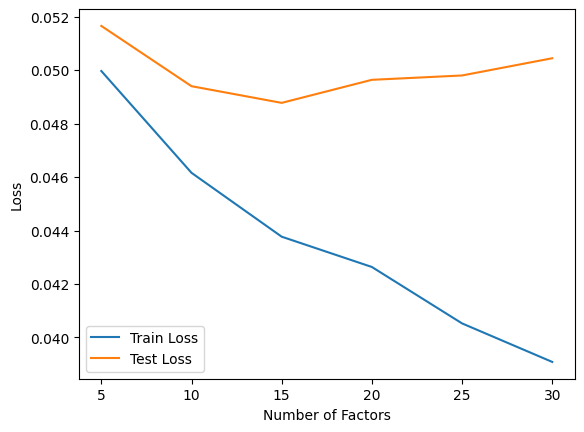

Best Number of Factors: 15
Train Loss: 0.04376862
Test Loss: 0.04877477


In [21]:
# Evaluate the number of factors
best_factors, train_loss, test_loss = df.evaluate_num_factors(num_factors_list=np.arange(5, 35, 5), num_iters=10)
print("Best Number of Factors:", best_factors)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

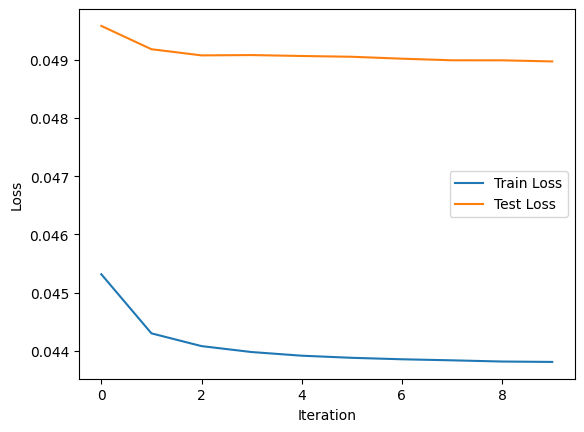

Best Iteration: 9
Train Loss: 0.043811556
Test Loss: 0.04897056


In [22]:
# Evaluate the train vs test losses
best_iter, train_loss, test_loss = df.evaluate_train_vs_test_losses(num_factors=best_factors, num_iters=10)
print("Best Iteration:", best_iter)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

In [23]:
df.give_example(num_factors=best_factors, num_iters=best_iter, num_samples=20)

Movie Index: 999, User Index: 136, Actual Rating: 3, Predicted Rating: 3.1144649982452393
Movie Index: 793, User Index: 604, Actual Rating: 4, Predicted Rating: 4.408909797668457
Movie Index: 414, User Index: 50, Actual Rating: 1, Predicted Rating: 1.5699213743209839
Movie Index: 450, User Index: 48, Actual Rating: 5, Predicted Rating: 4.533327579498291
Movie Index: 855, User Index: 79, Actual Rating: 4, Predicted Rating: 3.6151673793792725
Movie Index: 382, User Index: 184, Actual Rating: 3, Predicted Rating: 3.6017191410064697
Movie Index: 896, User Index: 172, Actual Rating: 3, Predicted Rating: 2.957664728164673
Movie Index: 472, User Index: 485, Actual Rating: 4, Predicted Rating: 2.1048405170440674
Movie Index: 31, User Index: 599, Actual Rating: 4, Predicted Rating: 3.7740046977996826
Movie Index: 560, User Index: 691, Actual Rating: 3, Predicted Rating: 2.991265296936035
Movie Index: 862, User Index: 130, Actual Rating: 4, Predicted Rating: 3.2541298866271973
Movie Index: 793, 